## Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import KFold

### 모델 학습 graph 

In [2]:
def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()

모델이 학습한 후의 그래프를 보여줍니다.  
정확도와 오차를 보기 쉽게 비교해줍니다.

### alphabet image

In [3]:
def digit_image(x):
    return np.where(x>=150, x, 0)

원본 이미지에서 숫자만 따로 추출하는 함수입니다.  
숫자 전부가 아닌 알파벳 마스크 때문에 가려진 부분은 추출되지 않을 것 입니다.

## Train

In [4]:
with open('./pickle/data.npy', 'rb') as f:
    X_trains= np.load(f)
    y_trains = np.load(f)
    TEST = np.load(f)

In [5]:
print(X_trains.shape)
print(y_trains.shape)
print(TEST.shape)

(2048, 28, 28, 3)
(2048, 10)
(20480, 28, 28, 3)


In [6]:
X_trains = X_trains.astype('float32') / 255.
TEST = TEST.astype('float32') / 255.

In [10]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import SeparableConv2D, Input, Conv2D, Add, BatchNormalization, concatenate, AveragePooling2D, add, MaxPooling2D 
from tensorflow.keras.layers import Conv2DTranspose,MaxPool2D, Flatten, Activation, Dropout,UpSampling2D, GlobalAveragePooling2D, Dense ,ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import sparse_categorical_crossentropy

### DenseNet

In [11]:
def Conv_block(x, growth_rate, activation='relu'):
    x_l = BatchNormalization()(x)
    x_l = Activation(activation)(x_l)
    x_l = Conv2D(growth_rate*4, (1,1), padding='same', kernel_initializer='he_normal')(x_l)
    
    x_l = BatchNormalization()(x_l)
    x_l = Activation(activation)(x_l)
    x_l = Conv2D(growth_rate, (3,3), padding='same', kernel_initializer='he_normal')(x_l)
    
    x = concatenate([x, x_l])
    return x

def Dense_block(x, layers, growth_rate=32):
    for i in range(layers):
        x = Conv_block(x, growth_rate)
    return x

def Transition_layer(x, compression_factor=0.5, activation='relu'):
    reduced_filters = int(tf.keras.backend.int_shape(x)[-1] * compression_factor)
    
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(reduced_filters, (1,1), padding='same', kernel_initializer='he_normal')(x)
    
    x = AveragePooling2D((2,2), padding='same', strides=2)(x)
    return x

def DenseNet(shape=(28,28,3), classes = 10, densenet_type='DenseNet-121'):
    inputs = Input(shape)
    base_growth_rate = 32
    
    x = Conv2D(base_growth_rate*2, (5,5), padding='same', strides=1,
               kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = MaxPooling2D((2,2), padding='same', strides=1)(x)
    
    x = Dense_block(x, layers_in_block[densenet_type][0], base_growth_rate)
    x = Transition_layer(x, compression_factor=0.5)
    x = Dense_block(x, layers_in_block[densenet_type][1], base_growth_rate)
    x = Transition_layer(x, compression_factor=0.5)
    x = Dense_block(x, layers_in_block[densenet_type][2], base_growth_rate)
#     x = Transition_layer(x, compression_factor=0.5)
#     x = Dense_block(x, layers_in_block[densenet_type][3], base_growth_rate)
    x = GlobalAveragePooling2D()(x)
#     x = Activation('relu')(x)
    
#     x = MaxPool2D((2,2), strides = 2)(x)
    
#     # FC layers
#     x = Flatten()(x)
#     x = Dense(512, activation = 'relu')(x)
#     x = Dropout(rate = 0.5)(x)
#     x = Dense(512, activation = 'relu')(x)
#     x = Dropout(rate = 0.5)(x)
    
    x = Dense(classes, kernel_initializer='he_normal')(x)
    outputs = Activation('softmax', dtype='float32')(x)
        
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

In [12]:
layers_in_block = {'DenseNet-121':[6, 12, 24, 16],
                   'DenseNet-169':[6, 12, 32, 32],
                   'DenseNet-201':[6, 12, 48, 32],
                   'DenseNet-265':[6, 12, 64, 48],
                   'myDenseNet':[8, 12, 16, 32]}

model = DenseNet()

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_87 (Conv2D)              (None, 28, 28, 64)   4864        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_87 (BatchNo (None, 28, 28, 64)   256         conv2d_87[0][0]                  
__________________________________________________________________________________________________
activation_88 (Activation)      (None, 28, 28, 64)   0           batch_normalization_87[0][0]     
______________________________________________________________________________________________

In [13]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    fill_mode='nearest'
)
datagen.fit(X_trains)

In [14]:
TEST

array([[[[0.        , 0.        , 0.        ],
         [0.01568628, 0.        , 0.01568628],
         [0.        , 0.        , 0.        ],
         ...,
         [0.00784314, 0.        , 0.00784314],
         [0.01568628, 0.        , 0.01568628],
         [0.00392157, 0.        , 0.00392157]],

        [[0.        , 0.        , 0.        ],
         [0.00392157, 0.        , 0.00392157],
         [0.00784314, 0.        , 0.00784314],
         ...,
         [0.01568628, 0.        , 0.01568628],
         [0.        , 0.        , 0.        ],
         [0.00784314, 0.        , 0.00784314]],

        [[0.00392157, 0.        , 0.00392157],
         [0.00784314, 0.        , 0.00784314],
         [0.01568628, 0.        , 0.01568628],
         ...,
         [0.00784314, 0.        , 0.00784314],
         [0.01568628, 0.        , 0.01568628],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.00392157, 0.        , 0.00392157],
         [0.        , 0.        , 0.        ]

In [21]:
# 많은 데이터 셋으로 학습시키기 위해 FOLD를 100으로 설정했습니다. Fold 1 중간에 Stop시켰기에 break 조건을 넣어놨습니다.
def get_stacking(in_model, train, train_y, n_fold = 10, SEED=2020):
    k_fold = KFold(n_splits=8, shuffle=True, random_state=SEED)
    
    epochs = 300
    model_number = 0
    history = []
    batch_size = 32
    val_predict = []

    train_fold_predict = np.zeros((train.shape[0], 1))
    test_predict = []
    arm_test_predict = np.array([0]*204800).reshape(20480, 10).astype('float64')
    
    for cnt, (train_idx, val_idx) in enumerate(k_fold.split(train, train_y)):
        print(f'*******************number_{cnt+1}_kfold_model*******************')
        x_train, y_train = train[train_idx], train_y[train_idx]
        x_val, y_val = train[val_idx], train_y[val_idx]
        
        model = in_model(train.shape[1:])
        model.compile(loss="categorical_crossentropy",
                      optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), 
                      metrics=["accuracy"])

        es = EarlyStopping(patience=15, verbose=1)
        mc = ModelCheckpoint(f'model1_best_{model_number}.h5', save_best_only=True, verbose=1)
        rlp = ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.8, min_lr=0.0001)
        
        history = model.fit(datagen.flow(x_train, y_train, shuffle=True, batch_size=batch_size),
                                  epochs=epochs,
                                  validation_data=(x_val, y_val),
                                  verbose=1,
                                  steps_per_epoch=x_train.shape[0] // batch_size,
                                  validation_steps=x_val.shape[0] // batch_size,
                                  callbacks=[es, mc, rlp])
        
        plot_curve(history.epoch, history.history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])
        
        
        model.load_weights(f'model1_best_{model_number}.h5')
        pred_train = model.predict(x_val)
        pred_test = model.predict(TEST)
        train_fold_predict[val_idx, :] = np.argmax(pred_train, 1).reshape((x_val.shape[0], 1))
        
        test_predict.append(pred_test)
    
    for pred_test in test_predict:
        arm_test_predict += pred_test
          
    test_fold_predict = np.argmax(arm_test_predict, axis=1).reshape((TEST.shape[0], 1))
    train_fold_predict = train_fold_predict.astype('int64')
    
    return train_fold_predict, test_fold_predict

## Predict

*******************number_1_kfold_model*******************
Epoch 1/300
56/56 [==============================] - ETA: 0s - loss: 2.7520 - accuracy: 0.1730
Epoch 00001: val_loss improved from inf to 3.09390, saving model to model1_best_0.h5
56/56 [==============================] - 6s 102ms/step - loss: 2.7520 - accuracy: 0.1730 - val_loss: 3.0939 - val_accuracy: 0.1172 - lr: 0.0010
Epoch 2/300
56/56 [==============================] - ETA: 0s - loss: 2.1667 - accuracy: 0.2612
Epoch 00002: val_loss did not improve from 3.09390
56/56 [==============================] - 4s 74ms/step - loss: 2.1667 - accuracy: 0.2612 - val_loss: 3.1565 - val_accuracy: 0.0781 - lr: 0.0010
Epoch 3/300
56/56 [==============================] - ETA: 0s - loss: 2.1305 - accuracy: 0.2812
Epoch 00003: val_loss did not improve from 3.09390
56/56 [==============================] - 4s 73ms/step - loss: 2.1305 - accuracy: 0.2812 - val_loss: 3.1313 - val_accuracy: 0.1289 - lr: 0.0010
Epoch 4/300
56/56 [====================

Epoch 28/300
56/56 [==============================] - ETA: 0s - loss: 0.7086 - accuracy: 0.7483
Epoch 00028: val_loss improved from 0.87914 to 0.74180, saving model to model1_best_0.h5
56/56 [==============================] - 5s 81ms/step - loss: 0.7086 - accuracy: 0.7483 - val_loss: 0.7418 - val_accuracy: 0.7500 - lr: 6.4000e-04
Epoch 29/300
56/56 [==============================] - ETA: 0s - loss: 0.7039 - accuracy: 0.7701
Epoch 00029: val_loss did not improve from 0.74180
56/56 [==============================] - 4s 69ms/step - loss: 0.7039 - accuracy: 0.7701 - val_loss: 1.3797 - val_accuracy: 0.6445 - lr: 6.4000e-04
Epoch 30/300
56/56 [==============================] - ETA: 0s - loss: 0.6812 - accuracy: 0.7584
Epoch 00030: val_loss did not improve from 0.74180
56/56 [==============================] - 4s 68ms/step - loss: 0.6812 - accuracy: 0.7584 - val_loss: 1.7017 - val_accuracy: 0.6523 - lr: 6.4000e-04
Epoch 31/300
56/56 [==============================] - ETA: 0s - loss: 0.7280 - a

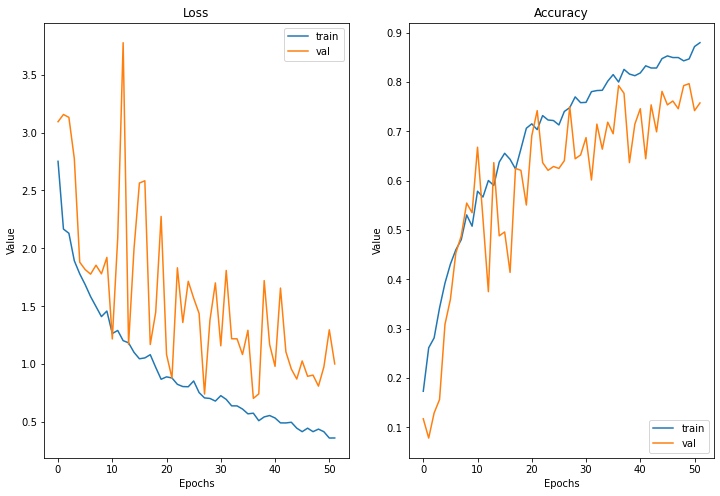

[[2.54763523e-04 8.99625434e-07 7.63799821e-04 ... 2.00036609e-07
  1.51559319e-02 1.14593934e-06]
 [1.16970968e-02 1.29274724e-07 1.91416719e-03 ... 3.09217809e-04
  6.80657625e-01 1.35551870e-01]
 [8.68644565e-06 1.33235609e-08 7.66158998e-02 ... 2.23569236e-06
  8.74821305e-01 9.92791865e-06]
 ...
 [7.09262211e-04 6.53924959e-09 8.29766759e-06 ... 1.61163116e-09
  2.40811991e-04 3.58315873e-07]
 [1.09655724e-04 1.63371124e-06 3.91626032e-04 ... 2.88118281e-06
  6.85762241e-02 9.33976480e-05]
 [9.99921083e-01 2.63507965e-11 1.35107048e-05 ... 7.22996152e-09
  5.02209559e-07 6.34569597e-09]]
*******************number_2_kfold_model*******************
Epoch 1/300
56/56 [==============================] - ETA: 0s - loss: 2.8839 - accuracy: 0.1445
Epoch 00001: val_loss improved from inf to 2.53975, saving model to model1_best_0.h5
56/56 [==============================] - 6s 99ms/step - loss: 2.8839 - accuracy: 0.1445 - val_loss: 2.5397 - val_accuracy: 0.1641 - lr: 0.0010
Epoch 2/300
56/56 

Epoch 26/300
56/56 [==============================] - ETA: 0s - loss: 0.7522 - accuracy: 0.7511
Epoch 00026: val_loss did not improve from 0.82552
56/56 [==============================] - 4s 69ms/step - loss: 0.7522 - accuracy: 0.7511 - val_loss: 1.4360 - val_accuracy: 0.6367 - lr: 5.1200e-04
Epoch 27/300
56/56 [==============================] - ETA: 0s - loss: 0.7630 - accuracy: 0.7383
Epoch 00027: val_loss did not improve from 0.82552
56/56 [==============================] - 4s 68ms/step - loss: 0.7630 - accuracy: 0.7383 - val_loss: 1.4147 - val_accuracy: 0.6719 - lr: 5.1200e-04
Epoch 28/300
56/56 [==============================] - ETA: 0s - loss: 0.7086 - accuracy: 0.7645
Epoch 00028: val_loss improved from 0.82552 to 0.75058, saving model to model1_best_0.h5
56/56 [==============================] - 4s 80ms/step - loss: 0.7086 - accuracy: 0.7645 - val_loss: 0.7506 - val_accuracy: 0.7695 - lr: 4.0960e-04
Epoch 29/300
56/56 [==============================] - ETA: 0s - loss: 0.6690 - a

Epoch 54/300
56/56 [==============================] - ETA: 0s - loss: 0.3661 - accuracy: 0.8756
Epoch 00054: val_loss did not improve from 0.53315
56/56 [==============================] - 4s 75ms/step - loss: 0.3661 - accuracy: 0.8756 - val_loss: 0.6025 - val_accuracy: 0.8281 - lr: 1.3422e-04
Epoch 55/300
56/56 [==============================] - ETA: 0s - loss: 0.3518 - accuracy: 0.8800 ETA: 0s - loss: 0.3477 - accuracy: 0.88
Epoch 00055: val_loss did not improve from 0.53315
56/56 [==============================] - 4s 73ms/step - loss: 0.3518 - accuracy: 0.8800 - val_loss: 1.0156 - val_accuracy: 0.7656 - lr: 1.3422e-04
Epoch 56/300
56/56 [==============================] - ETA: 0s - loss: 0.3538 - accuracy: 0.8811
Epoch 00056: val_loss did not improve from 0.53315
56/56 [==============================] - 4s 70ms/step - loss: 0.3538 - accuracy: 0.8811 - val_loss: 0.7892 - val_accuracy: 0.7734 - lr: 1.3422e-04
Epoch 57/300
56/56 [==============================] - ETA: 0s - loss: 0.3487 -

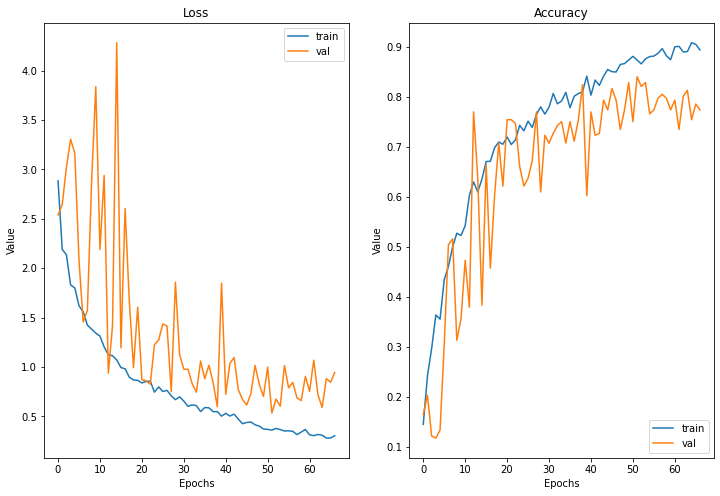

[[9.0088841e-05 7.1035117e-08 3.2687366e-02 ... 1.4022867e-06
  1.1031524e-03 3.6334620e-06]
 [1.2625336e-03 2.9720721e-09 2.0236680e-03 ... 3.4899518e-04
  4.0404387e-03 9.8977977e-01]
 [6.1293417e-06 5.8542309e-07 2.4117613e-01 ... 4.7457771e-04
  6.8470126e-01 3.2126652e-03]
 ...
 [4.4766354e-04 5.7746757e-10 6.9835478e-06 ... 6.1173231e-09
  2.6866264e-06 7.0317151e-07]
 [1.0383928e-05 2.0401742e-06 1.4074754e-03 ... 9.0924450e-06
  5.2513853e-02 3.1173287e-03]
 [9.9998915e-01 9.2679315e-13 7.0729743e-06 ... 7.5679549e-07
  1.7489691e-09 4.4838366e-08]]
*******************number_3_kfold_model*******************
Epoch 1/300
56/56 [==============================] - ETA: 0s - loss: 2.9733 - accuracy: 0.1590
Epoch 00001: val_loss improved from inf to 2.45568, saving model to model1_best_0.h5
56/56 [==============================] - 6s 115ms/step - loss: 2.9733 - accuracy: 0.1590 - val_loss: 2.4557 - val_accuracy: 0.1016 - lr: 0.0010
Epoch 2/300
56/56 [==============================] - 

Epoch 26/300
56/56 [==============================] - ETA: 0s - loss: 0.8292 - accuracy: 0.7221
Epoch 00026: val_loss did not improve from 0.75099
56/56 [==============================] - 4s 74ms/step - loss: 0.8292 - accuracy: 0.7221 - val_loss: 1.2313 - val_accuracy: 0.7031 - lr: 6.4000e-04
Epoch 27/300
56/56 [==============================] - ETA: 0s - loss: 0.7529 - accuracy: 0.7450
Epoch 00027: val_loss did not improve from 0.75099
56/56 [==============================] - 4s 74ms/step - loss: 0.7529 - accuracy: 0.7450 - val_loss: 1.2737 - val_accuracy: 0.6719 - lr: 6.4000e-04
Epoch 28/300
56/56 [==============================] - ETA: 0s - loss: 0.7153 - accuracy: 0.7600
Epoch 00028: val_loss improved from 0.75099 to 0.73873, saving model to model1_best_0.h5
56/56 [==============================] - 5s 87ms/step - loss: 0.7153 - accuracy: 0.7600 - val_loss: 0.7387 - val_accuracy: 0.7969 - lr: 6.4000e-04
Epoch 29/300
56/56 [==============================] - ETA: 0s - loss: 0.7873 - a

Epoch 00053: early stopping


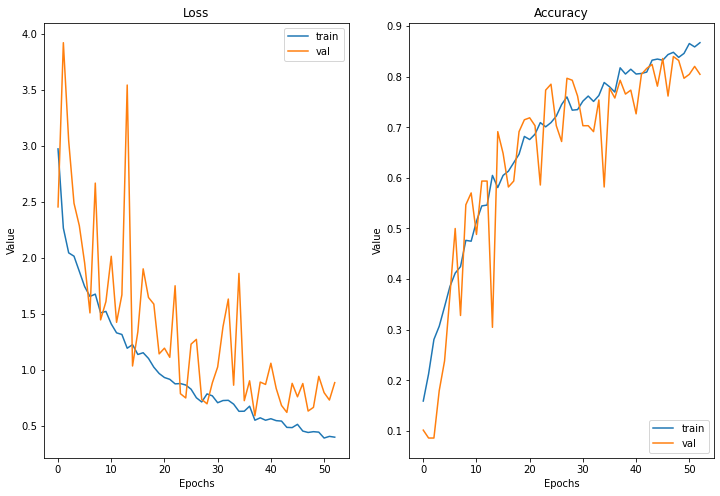

[[2.1371739e-03 9.0776621e-06 7.9691429e-03 ... 9.1337657e-05
  1.1707241e-01 1.9636880e-04]
 [1.9100140e-04 1.8478395e-06 5.5651326e-06 ... 1.9546004e-03
  3.0047307e-02 9.6016914e-01]
 [1.1544661e-02 2.0520772e-06 4.6592437e-02 ... 2.5212006e-03
  4.7407827e-01 2.2338038e-04]
 ...
 [2.1937615e-04 2.5391495e-08 3.6803797e-07 ... 1.2365713e-07
  6.3357570e-06 2.0982045e-06]
 [2.3044780e-05 5.0398364e-04 7.3526765e-04 ... 2.3866091e-04
  9.5464242e-01 3.8404346e-03]
 [9.9304008e-01 1.2947722e-09 8.1799488e-04 ... 4.9198320e-06
  2.2807726e-05 8.7729331e-06]]
*******************number_4_kfold_model*******************
Epoch 1/300
56/56 [==============================] - ETA: 0s - loss: 2.9753 - accuracy: 0.1412
Epoch 00001: val_loss improved from inf to 2.77532, saving model to model1_best_0.h5
56/56 [==============================] - 5s 98ms/step - loss: 2.9753 - accuracy: 0.1412 - val_loss: 2.7753 - val_accuracy: 0.1055 - lr: 0.0010
Epoch 2/300
56/56 [==============================] - E

Epoch 26/300
56/56 [==============================] - ETA: 0s - loss: 0.8668 - accuracy: 0.7070
Epoch 00026: val_loss did not improve from 0.57174
56/56 [==============================] - 4s 74ms/step - loss: 0.8668 - accuracy: 0.7070 - val_loss: 0.7499 - val_accuracy: 0.7617 - lr: 6.4000e-04
Epoch 27/300
56/56 [==============================] - ETA: 0s - loss: 0.8669 - accuracy: 0.6925
Epoch 00027: val_loss did not improve from 0.57174
56/56 [==============================] - 4s 74ms/step - loss: 0.8669 - accuracy: 0.6925 - val_loss: 1.2159 - val_accuracy: 0.7031 - lr: 6.4000e-04
Epoch 28/300
56/56 [==============================] - ETA: 0s - loss: 0.8192 - accuracy: 0.7294
Epoch 00028: val_loss did not improve from 0.57174
56/56 [==============================] - 4s 74ms/step - loss: 0.8192 - accuracy: 0.7294 - val_loss: 0.8823 - val_accuracy: 0.7383 - lr: 6.4000e-04
Epoch 29/300
56/56 [==============================] - ETA: 0s - loss: 0.8033 - accuracy: 0.7249
Epoch 00029: val_loss 

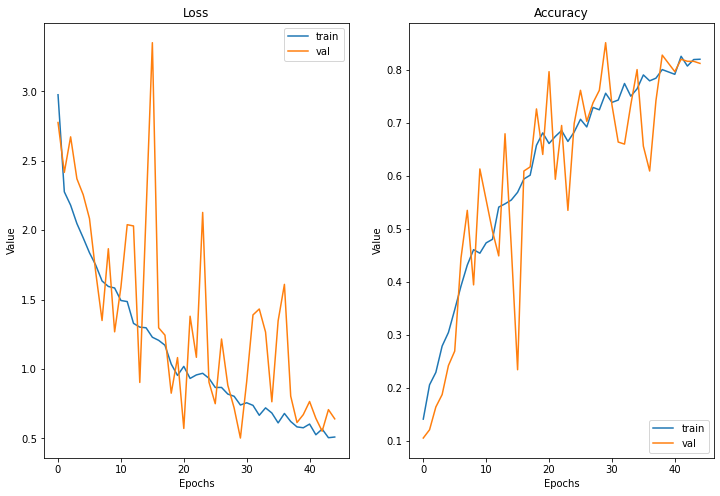

[[2.15861481e-03 5.69339463e-05 2.79236734e-02 ... 9.71881163e-05
  7.59847313e-02 5.78119187e-04]
 [8.05131742e-04 1.88710928e-05 1.04038389e-02 ... 1.66213244e-01
  5.39001673e-02 3.20566714e-01]
 [1.52420835e-05 1.47526007e-04 8.95904839e-01 ... 1.33340303e-02
  1.24770002e-02 6.04424684e-04]
 ...
 [6.20591501e-03 6.48317337e-06 1.14558917e-03 ... 1.74599554e-05
  3.35815566e-04 4.12840018e-05]
 [4.35234047e-03 6.49874040e-04 9.75533295e-03 ... 4.45971917e-03
  2.96660010e-02 3.12367696e-02]
 [9.29789066e-01 3.79939813e-08 6.37082830e-02 ... 1.96406356e-04
  1.03842685e-05 1.18200565e-04]]
*******************number_5_kfold_model*******************
Epoch 1/300
56/56 [==============================] - ETA: 0s - loss: 2.9753 - accuracy: 0.1479
Epoch 00001: val_loss improved from inf to 2.51692, saving model to model1_best_0.h5
56/56 [==============================] - 6s 106ms/step - loss: 2.9753 - accuracy: 0.1479 - val_loss: 2.5169 - val_accuracy: 0.1445 - lr: 0.0010
Epoch 2/300
56/56

Epoch 26/300
56/56 [==============================] - ETA: 0s - loss: 0.7647 - accuracy: 0.7388
Epoch 00026: val_loss did not improve from 1.01069
56/56 [==============================] - 4s 73ms/step - loss: 0.7647 - accuracy: 0.7388 - val_loss: 1.0620 - val_accuracy: 0.6992 - lr: 5.1200e-04
Epoch 27/300
56/56 [==============================] - ETA: 0s - loss: 0.7024 - accuracy: 0.7511
Epoch 00027: val_loss improved from 1.01069 to 0.71243, saving model to model1_best_0.h5
56/56 [==============================] - 5s 86ms/step - loss: 0.7024 - accuracy: 0.7511 - val_loss: 0.7124 - val_accuracy: 0.7969 - lr: 5.1200e-04
Epoch 28/300
56/56 [==============================] - ETA: 0s - loss: 0.6550 - accuracy: 0.7757
Epoch 00028: val_loss did not improve from 0.71243
56/56 [==============================] - 4s 73ms/step - loss: 0.6550 - accuracy: 0.7757 - val_loss: 1.3117 - val_accuracy: 0.6992 - lr: 5.1200e-04
Epoch 29/300
56/56 [==============================] - ETA: 0s - loss: 0.7694 - a

Epoch 54/300
56/56 [==============================] - ETA: 0s - loss: 0.3370 - accuracy: 0.8890
Epoch 00054: val_loss did not improve from 0.55082
56/56 [==============================] - 4s 73ms/step - loss: 0.3370 - accuracy: 0.8890 - val_loss: 0.8287 - val_accuracy: 0.7734 - lr: 1.3422e-04
Epoch 55/300
56/56 [==============================] - ETA: 0s - loss: 0.3548 - accuracy: 0.8767
Epoch 00055: val_loss did not improve from 0.55082
56/56 [==============================] - 4s 73ms/step - loss: 0.3548 - accuracy: 0.8767 - val_loss: 0.7979 - val_accuracy: 0.7695 - lr: 1.3422e-04
Epoch 00055: early stopping


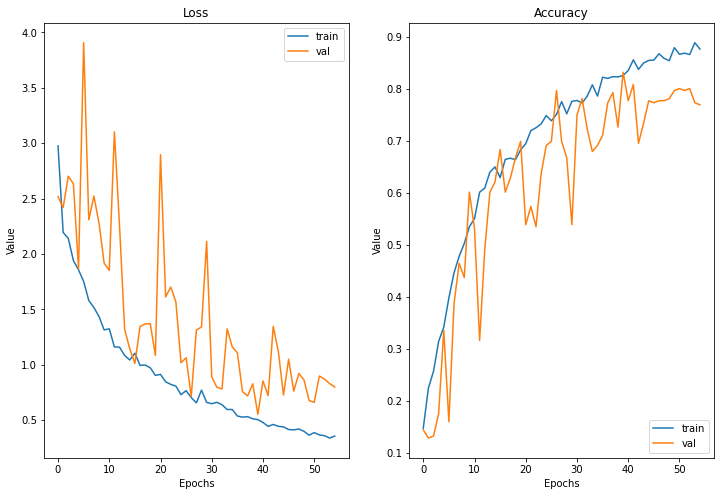

[[2.6638954e-04 1.7300596e-07 1.9227952e-02 ... 3.6320369e-06
  9.1637805e-02 3.8922633e-04]
 [4.2442875e-03 1.2669705e-07 4.6315067e-04 ... 4.7355872e-03
  5.7839672e-03 9.8469710e-01]
 [5.2155428e-06 6.1106010e-07 9.6601325e-01 ... 2.8254138e-04
  3.2351129e-02 4.4822617e-04]
 ...
 [2.9032060e-04 2.2939353e-09 8.5281594e-05 ... 3.7521719e-08
  1.0134894e-05 2.3185278e-06]
 [6.1394712e-06 8.8675542e-06 1.5797042e-03 ... 1.9728714e-05
  9.9345219e-01 3.7198327e-03]
 [9.9999046e-01 5.3238844e-11 2.8497070e-06 ... 3.7060083e-08
  3.6975287e-08 3.6768448e-08]]
*******************number_6_kfold_model*******************
Epoch 1/300
56/56 [==============================] - ETA: 0s - loss: 2.7388 - accuracy: 0.1468
Epoch 00001: val_loss improved from inf to 5.42386, saving model to model1_best_0.h5
56/56 [==============================] - 6s 102ms/step - loss: 2.7388 - accuracy: 0.1468 - val_loss: 5.4239 - val_accuracy: 0.0742 - lr: 0.0010
Epoch 2/300
56/56 [==============================] - 

Epoch 26/300
56/56 [==============================] - ETA: 0s - loss: 0.7995 - accuracy: 0.7400
Epoch 00026: val_loss did not improve from 1.06614
56/56 [==============================] - 4s 74ms/step - loss: 0.7995 - accuracy: 0.7400 - val_loss: 1.6507 - val_accuracy: 0.5820 - lr: 6.4000e-04
Epoch 27/300
56/56 [==============================] - ETA: 0s - loss: 0.7658 - accuracy: 0.7333
Epoch 00027: val_loss did not improve from 1.06614
56/56 [==============================] - 4s 73ms/step - loss: 0.7658 - accuracy: 0.7333 - val_loss: 1.3974 - val_accuracy: 0.6406 - lr: 6.4000e-04
Epoch 28/300
56/56 [==============================] - ETA: 0s - loss: 0.7647 - accuracy: 0.7444
Epoch 00028: val_loss improved from 1.06614 to 0.84918, saving model to model1_best_0.h5
56/56 [==============================] - 5s 87ms/step - loss: 0.7647 - accuracy: 0.7444 - val_loss: 0.8492 - val_accuracy: 0.7734 - lr: 5.1200e-04
Epoch 29/300
56/56 [==============================] - ETA: 0s - loss: 0.7017 - a

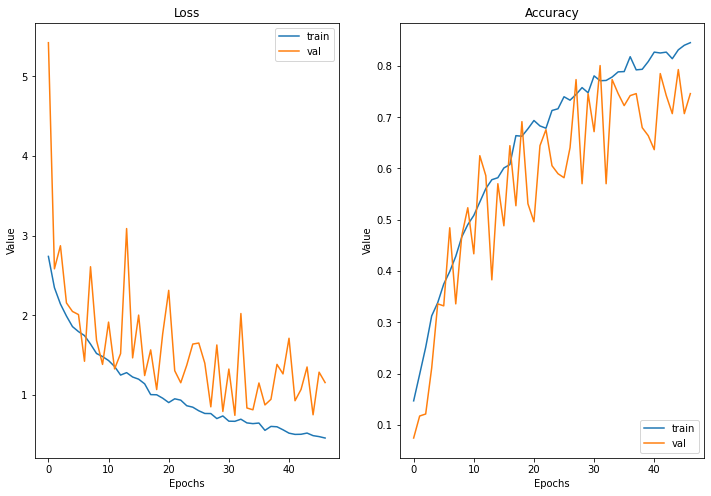

[[5.77223860e-03 1.23458858e-06 3.34440707e-03 ... 6.16714431e-07
  9.68423262e-02 1.30262015e-05]
 [7.54681707e-04 3.17267904e-07 5.45399453e-05 ... 3.14062607e-04
  1.91864115e-03 9.96345341e-01]
 [3.64852051e-04 2.84873249e-06 1.95332663e-03 ... 2.30842306e-05
  9.82307792e-01 2.19175272e-04]
 ...
 [1.57465655e-02 4.39683241e-08 2.53469716e-05 ... 9.39506606e-08
  7.49163955e-05 3.67372486e-05]
 [8.37486459e-06 8.41007295e-06 3.73882445e-04 ... 6.90247361e-07
  7.83700645e-01 1.16540068e-04]
 [9.99966860e-01 1.71855568e-11 7.31270404e-07 ... 5.69471830e-08
  6.70921168e-08 2.18033094e-07]]
*******************number_7_kfold_model*******************
Epoch 1/300
56/56 [==============================] - ETA: 0s - loss: 2.8758 - accuracy: 0.1568
Epoch 00001: val_loss improved from inf to 5.00597, saving model to model1_best_0.h5
56/56 [==============================] - 6s 104ms/step - loss: 2.8758 - accuracy: 0.1568 - val_loss: 5.0060 - val_accuracy: 0.0938 - lr: 0.0010
Epoch 2/300
56/56

Epoch 26/300
56/56 [==============================] - ETA: 0s - loss: 0.8078 - accuracy: 0.7160
Epoch 00026: val_loss did not improve from 0.75522
56/56 [==============================] - 4s 73ms/step - loss: 0.8078 - accuracy: 0.7160 - val_loss: 1.6740 - val_accuracy: 0.5977 - lr: 8.0000e-04
Epoch 27/300
56/56 [==============================] - ETA: 0s - loss: 0.7517 - accuracy: 0.7327
Epoch 00027: val_loss did not improve from 0.75522
56/56 [==============================] - 4s 73ms/step - loss: 0.7517 - accuracy: 0.7327 - val_loss: 1.4645 - val_accuracy: 0.6250 - lr: 8.0000e-04
Epoch 28/300
56/56 [==============================] - ETA: 0s - loss: 0.7649 - accuracy: 0.7360
Epoch 00028: val_loss improved from 0.75522 to 0.73716, saving model to model1_best_0.h5
56/56 [==============================] - 5s 86ms/step - loss: 0.7649 - accuracy: 0.7360 - val_loss: 0.7372 - val_accuracy: 0.7773 - lr: 6.4000e-04
Epoch 29/300
56/56 [==============================] - ETA: 0s - loss: 0.7112 - a

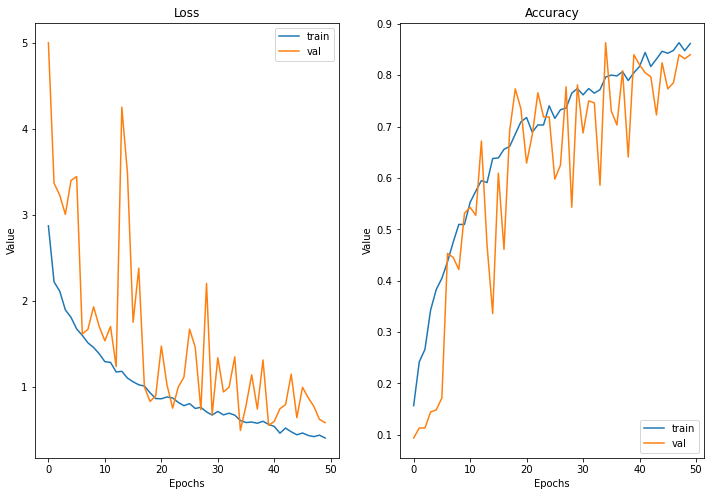

[[2.2445468e-03 9.6431850e-06 2.1018403e-02 ... 2.6056755e-06
  3.3484881e-03 4.5338060e-05]
 [3.6934461e-02 8.9573444e-07 3.0522386e-04 ... 8.4560126e-04
  7.6430659e-03 9.0697634e-01]
 [5.3677650e-04 1.6620364e-04 1.9687806e-01 ... 1.0679194e-04
  7.4204731e-01 7.2946023e-05]
 ...
 [1.7956983e-03 2.7962301e-07 1.3125994e-05 ... 1.0063323e-08
  3.1406111e-05 4.3811681e-07]
 [4.1302873e-04 1.6967277e-03 1.2083081e-02 ... 3.4215627e-04
  2.1844340e-02 8.6657694e-03]
 [9.9994683e-01 4.1755190e-09 4.8847814e-06 ... 1.0387933e-07
  1.7902410e-07 1.1056858e-08]]
*******************number_8_kfold_model*******************
Epoch 1/300
56/56 [==============================] - ETA: 0s - loss: 2.9347 - accuracy: 0.1657
Epoch 00001: val_loss improved from inf to 2.59167, saving model to model1_best_0.h5
56/56 [==============================] - 6s 105ms/step - loss: 2.9347 - accuracy: 0.1657 - val_loss: 2.5917 - val_accuracy: 0.0938 - lr: 0.0010
Epoch 2/300
56/56 [==============================] - 

Epoch 26/300
56/56 [==============================] - ETA: 0s - loss: 0.7162 - accuracy: 0.7595
Epoch 00026: val_loss did not improve from 0.59698
56/56 [==============================] - 4s 74ms/step - loss: 0.7162 - accuracy: 0.7595 - val_loss: 1.2413 - val_accuracy: 0.6953 - lr: 5.1200e-04
Epoch 27/300
56/56 [==============================] - ETA: 0s - loss: 0.7278 - accuracy: 0.7506
Epoch 00027: val_loss did not improve from 0.59698
56/56 [==============================] - 4s 74ms/step - loss: 0.7278 - accuracy: 0.7506 - val_loss: 0.7258 - val_accuracy: 0.7969 - lr: 5.1200e-04
Epoch 28/300
56/56 [==============================] - ETA: 0s - loss: 0.6823 - accuracy: 0.7606
Epoch 00028: val_loss did not improve from 0.59698
56/56 [==============================] - 4s 73ms/step - loss: 0.6823 - accuracy: 0.7606 - val_loss: 0.8882 - val_accuracy: 0.7383 - lr: 4.0960e-04
Epoch 29/300
56/56 [==============================] - ETA: 0s - loss: 0.6404 - accuracy: 0.7896
Epoch 00029: val_loss 

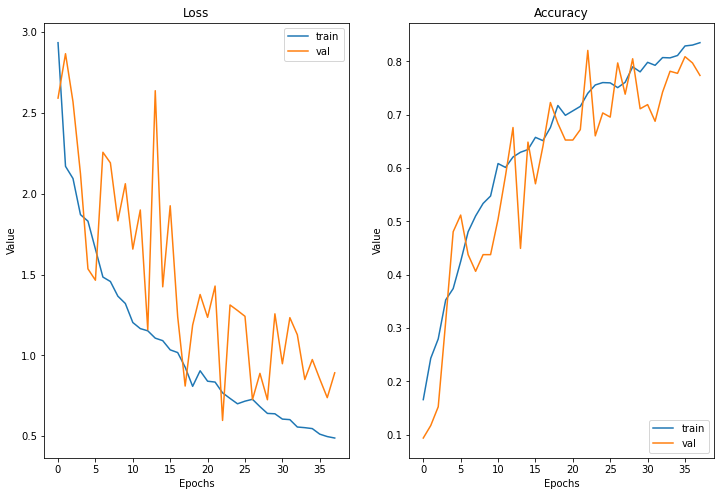

[[4.7670589e-03 3.1536470e-05 6.7915641e-02 ... 6.8824134e-05
  2.1470606e-01 2.1548697e-04]
 [1.0358720e-03 2.8654194e-06 3.1026485e-04 ... 7.3994364e-04
  1.3495587e-01 3.2076600e-01]
 [6.6541361e-05 5.0190010e-06 1.1438433e-03 ... 2.0091577e-05
  9.2663521e-01 1.2647826e-05]
 ...
 [5.9370388e-04 1.1218694e-08 9.9102028e-05 ... 3.3155580e-08
  1.4713993e-04 2.9331292e-07]
 [8.5645283e-05 1.5700162e-04 2.3647435e-03 ... 1.5174823e-05
  5.6196970e-01 2.8011785e-04]
 [9.9982905e-01 3.9893096e-11 1.0479671e-05 ... 3.5609153e-07
  2.1518211e-07 6.1979210e-07]]


In [22]:
DS_train, DS_test = get_stacking(DenseNet, X_trains, y_trains)

In [25]:
DS_test

array([[6],
       [9],
       [8],
       ...,
       [6],
       [3],
       [0]])

In [26]:
DS_test[70]

array([5])

In [27]:
DS_train

array([[5],
       [0],
       [4],
       ...,
       [9],
       [0],
       [5]])

## Pickle 파일 저장

In [28]:
pickle.dump(DS_train, open("./pickle/DS_train.pkl", "wb"))
pickle.dump(DS_test, open("./pickle/DS_test.pkl", "wb"))